<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/SP/He_H_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6> Wavelengths measurements with diffraction grating</font>

Evgeny Kolonsky, 2025

v.0.4.7

In [81]:
! pip install uncertainties

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy.optimize import fsolve
from uncertainties import ufloat, unumpy as unp
from uncertainties.umath import sin, atan, cos
from scipy.constants import *
import math


In [83]:
# weighted average
def umean(ux: unp.uarray) -> ufloat:
  values = unp.nominal_values(ux)
  uncertainties = unp.std_devs(ux)
  if np.prod(uncertainties) == 0: # algorythm fails when at  sigma=0
    res =  ufloat( np.mean(values), np.mean(uncertainties))
  else:
    weights = 1 / uncertainties**2
    weighted_average = sum(values * weights) / sum(weights)
    weighted_error = 1 / np.sqrt(sum(weights))
    res = ufloat(weighted_average, weighted_error)
  return res

RESOLUTION = 360 / 8000 # deg
beta_err = 2* RESOLUTION * np.pi / 180 # rad



# Model

Theoretical expression for light diffraction when incident light is assumed to be perpendicular to grating  is
$$    
n \lambda = d \sin \beta_n,
    \tag{1}    
$$
where $\lambda$ - light wave length, $d$ - diffraction grating parameter, $n$ - diffraction order number, $\beta_n$ - diffraction angle incident light and diffracted light of order $n$.

When incident light falls under an arbitrary angle $\alpha_0$ relative to the grating plane perpendicular, the expression is written in form \cite{PhysLabManual-1972}
$$
n \lambda = 2 d \sin \frac{\beta_n}{2} \cos\left(\alpha_0 +
\frac{\beta_n}{2} \right) , \quad n =  \pm 1, \pm 2, ..
\tag{2}   
$$

For $\alpha_0=0$ (light falls perpendicularly) we receive eq.(1).  


The unknown angle $\alpha_0$ between grating plane perpendicular and light beam can be found directly by measuring $\beta_{\pm n}$ of symmetric orders $\pm n$, even when  grating period $d$ and wavelength $\lambda$ are  unknown. Denoting for simplicity $\beta_+$ and $\beta_-$ diffraction angles for an arbitrary orders $\pm n$ in eq.(2), we have  
$$
\sin \frac{\beta_{+}}{2} \cos\left( \alpha_0 + \frac{\beta_{+}}{2}\right) + \sin \frac{\beta_{-}}{2} \cos\left( \alpha_0 + \frac{\beta_{-}}{2}\right) =0.
\tag{3}
$$
This is an equation with one unknown parameter $\alpha_0$. The solution is:
$$
\alpha_0 = \arctan\frac{\sin\beta_+ + \sin\beta_- }{2 - \cos\beta_+ -
\cos\beta_-}.
\tag{4}
$$



In [84]:

def get_alpha0(beta_plus, beta_minus):
  s1 = sin(beta_plus)
  s2 = sin(beta_minus)
  c1 = cos(beta_plus)
  c2 = cos(beta_minus)
  tan_alpha =  (s1 + s2) / (2 - c1 - c2)
  alpha0 = atan(tan_alpha)
  return alpha0

def get_ualpha0(n, colors, beta):
  betas = {}
  for ix, b in enumerate(beta):
      betas[(int(color_index[ix]), int(n[ix]))] = b

  alphas = {}
  for key in betas:
    c = key[0]
    order = key[1]
    if (c, order) in betas and (c, -order) in betas:
      bp = betas[(c, order)]
      bm = betas[(c, -order)]
      ubp = ufloat(bp, beta_err)
      ubm = ufloat(bm, beta_err)
      alphas[key] = get_alpha0(ubp, ubm)
  al_arr = np.array(list(alphas.values()))
  return umean(al_arr)

Automatic color assignment

In [85]:
def wavelength_to_color(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''
    wavelength = float(wavelength)
    if wavelength < 380:
        wavelength = 380.
    if wavelength > 750:
        wavelength = 750.
    if 380 <= wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif 490 <= wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif 580 <= wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    r = int(R*255)
    g = int(G*255)
    b = int(B*255)
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

# Measurements

## Helium

Measured with spectrograph

![He](https://github.com/tphlabs/data/blob/main/Lab4_SP/helium.png?raw=true')

Nominal values

In [86]:
lines = ['Unidentified', '1 Blue448', '2 Blue472',
          '3 Green492', '4 Green501', '5 Yellow588', '6 Red668', '7 Red707']
nominal_waves = [ np.nan, 447.2, 471.3, 492.1, 501.6, 587.6, 667.8, 706.5]
python_colors = ['gray'] + [wavelength_to_color(wl) for wl in nominal_waves[1:]]


## Calculate $\alpha_0$ and diffraction grating period $d$

In [87]:
measurements = '''
# order, color_index beta(degrees)
1 1 12.87
1 2 13.59
1 3 14.175
1 4 14.49
1 5 17.01
1 6 19.35
1 7 20.565
-1 1 -12.915
-1 2 -13.59
-1 3 -14.22
-1 4 -14.49
-1 5 -17.055
-1 6 -19.485
-1 7 -20.655
'''



n, color_index, beta = np.genfromtxt(measurements.splitlines(), unpack=True)

beta *= np.pi / 180

alpha0 = get_ualpha0(n, color_index, beta)
print(f'alpha0: {alpha0*180 / np.pi} degree')



lmbd = [nominal_waves[int(clr)]*1e-9 for clr in color_index]
d_arr = [n[i] * lmbd[i] / ( 2 * sin(beta[i]/2) * cos(alpha0 + beta[i]/2) ) for i in range(len(n))]
d_arr = np.array(d_arr)

d = umean(d_arr)
print(rf'Calculated d = {d *1e6} um')
#d = 2e-6 # 500 lines per mm
print(f'Nominal d is 500 lines per mm {d*1e6:0.1f} um')


alpha0: -0.7+/-0.4 degree
Calculated d = 2.0058+/-0.0005 um
Nominal d is 500 lines per mm 2.0+/-0.0 um


## Display on graph

2 Blue472      : nominal 471.3 lambda = 471.39+/-0.27 nm, 2 points
3 Green492     : nominal 492.1 lambda = 491.91+/-0.30 nm, 2 points
4 Green501     : nominal 501.6 lambda = 501.97+/-0.31 nm, 2 points
5 Yellow588    : nominal 587.6 lambda = 587.5+/-0.4 nm, 2 points
6 Red668       : nominal 667.8 lambda = 666.6+/-0.5 nm, 2 points
7 Red707       : nominal 706.5 lambda = 706.0+/-0.6 nm, 2 points


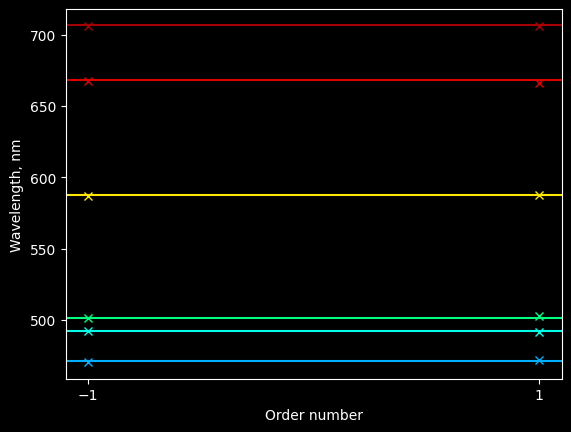

In [88]:
plt.style.use('dark_background')

for ix in range(2, len(lines)):
  b = beta[color_index == ix]
  n_ix =  n[color_index == ix]
  lmbd = np.array([2 * d *  sin(b[i] / 2) * cos(alpha0 + b[i] / 2) /n_ix[i] for i in range(len(b))])
  lmbd_mean = umean(lmbd)
  lmbd_n = len(lmbd)
  print(rf'{lines[ix]:<15}: nominal {nominal_waves[ix]} lambda = {lmbd_mean*1e9} nm, {lmbd_n:d} points' )


  plt.plot(n_ix, unp.nominal_values(lmbd) *1e9, 'x', color=python_colors[ix])
  plt.axhline(nominal_waves[ix], color=python_colors[ix])
  plt.xticks([int(nx) for nx in np.unique(n)])
  plt.xlabel('Order number')
  plt.ylabel(r'Wavelength, nm')
  #plt.legend()


## Hydrogen

Measured with spectrograph

![H](https://github.com/tphlabs/data/blob/main/Lab4_SP/hydrogen.png?raw=true')

Nominal values

In [89]:
lines = ['Unidentified', '1 Violet 434', '2 Cian 486', '3 Red 657']
nominal_waves = [np.nan, 434.0, 486.1, 656.3]
python_colors = ['gray'] + [wavelength_to_color(wl) for wl in nominal_waves[1:]]
quantum_numbers = [5, 4, 3]

## Calculate $\alpha_0$ and wavelengths, after that display




d = 2.006+/-0.000 um
alpha0: -0.46+/-0.08 degree
1 Violet 434   : nominal 434.0 lambda = 434.40+/-0.09 nm, 2 points
2 Cian 486     : nominal 486.1 lambda = 485.77+/-0.08 nm, 6 points
3 Red 657      : nominal 656.3 lambda = 656.24+/-0.13 nm, 4 points


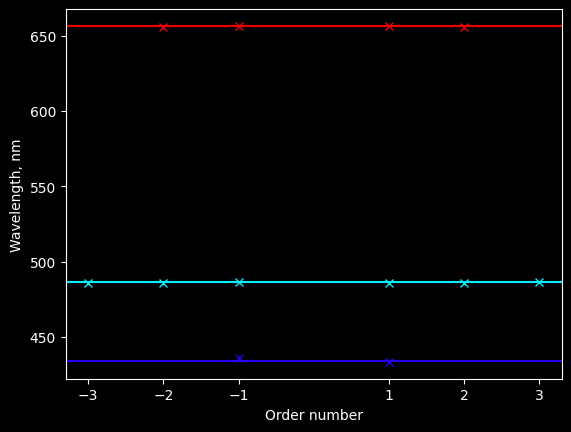

In [90]:
# d = 2e-6 # nominal
# we will reuse d value found above
print(rf'd = {d*1e6:.3f} um')

measurements = '''
# order, color_index beta
1 1 12.465
-1 1 -12.555
1 2 13.995
-1 2 -14.04
1 3 19.08
-1 3 -19.125
2 2 28.89
-2 2 -29.025
2 3 40.68
-2 3 -40.995
3 2 46.44 # hardly seen
-3 2 -46.845 # hardly seen
'''

n, color_index, beta = np.genfromtxt(measurements.splitlines(), unpack=True)

beta *= np.pi / 180

alpha0 = get_ualpha0(n, color_index, beta)
print(f'alpha0: {alpha0*180 / np.pi} degree')

l = []
for ix in range(1, len(lines)):
  b = beta[color_index == ix]
  n_ix =  n[color_index == ix]
  lmbd = np.array([2 * d *  sin(b[i] / 2) * cos(alpha0 + b[i] / 2) /n_ix[i] for i in range(len(b))])
  lmbd_mean = umean(lmbd)
  l.append(lmbd_mean)
  lmbd_n = len(lmbd)
  print(rf'{lines[ix]:<15}: nominal {nominal_waves[ix]} lambda = {lmbd_mean*1e9} nm, {lmbd_n:d} points' )

  plt.plot(n_ix, unp.nominal_values(lmbd) *1e9, 'x', color=python_colors[ix])
  plt.axhline(nominal_waves[ix], color=python_colors[ix])
  #plt.legend()
  plt.xticks([int(nx) for nx in np.unique(n)])
  plt.xlabel('Order number')
  plt.ylabel(r'Wavelength, nm')



# Rydberg's constant
$$
\frac{1}{\lambda} = R \left( \frac{1}{2^2} - \frac{1}{n^2}\right)
$$
where $n$ - quantum number:
$n=5$ for violet, $n=4$ for cian and $n=3$ for red line hydrogen spectrum.

In [111]:
x = 1/4 - 1/ np.array(quantum_numbers)**2
y = 1/np.array(l)
R = y / x
R_mean = umean(R)
print(f'Measured R     {R_mean:.4e} 1/m')
print(f'Reference       {Rydberg:.4e} 1/m')
R_air = 10970987 # 1/m
print(f'Reference R_air {R_air:.4e} 1/m')
print(f'Discrepancy of R measured / Reference in order of 10^{np.log10(np.abs(R_mean.n/Rydberg -1)):.0f}')



Measured R     (1.0972+/-0.0001)e+07 1/m
Reference       1.0974e+07 1/m
Reference R_air 1.0971e+07 1/m
Discrepancy of R measured / Reference in order of 10^-4


# References

- "Physics Laboratory Manual", 3d ed., Wall , Levine and Christensen, Experiment 75 Wave Length of Light: Diffraction Grating, p.297, eq.75.2 and 75.3
